# REX Quora Insincere Question Classification


**Theo for  the Kaggle Corner**

https://www.kaggle.com/c/quora-insincere-questions-classification

In [1]:
import re
import gc
import os
import time
import random
import operator
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
tqdm.pandas()

from sklearn.metrics import *
from nltk import word_tokenize
from collections import Counter
from sklearn.model_selection import *
from tqdm import tqdm_notebook as tqdm
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader

import psutil
import multiprocessing

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [2]:
begin = time.time()
sns.set_style('whitegrid')

In [3]:
GLOVE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
PARAGRAM = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
FASTTEXT = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

# Initialization

## Seeding

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.set_random_seed(seed)

In [5]:
seed = 6452

In [6]:
seed_everything(seed)

## Loading Data

In [7]:
train_df = pd.read_csv("../input/train.csv").head(100000)
test_df = pd.read_csv("../input/test.csv")

print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (100000, 3)
Test shape :  (375806, 2)


In [8]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [9]:
for q in test_df["question_text"][:5]:
    print(q)
    print('')

Why do so many women become so rude and arrogant when they get just a little bit of wealth and power?

When should I apply for RV college of engineering and BMS college of engineering? Should I wait for the COMEDK result or am I supposed to apply before the result?

What is it really like to be a nurse practitioner?

Who are entrepreneurs?

Is education really making good people nowadays?



# Text Features

- **Toxic word ratio** : The proportion of words in the sentence that are in a list of words labelled as toxic
- **Total length** : Length of the sentence as a string
- **Capital letters ratio** : PROPORTION OF LETTERS WRITTEN IN CAPS.
- **Unique word ratio** : Proportion of words in the sentence that appear only once
- **Average word frequency** : Frequency of the words in the sentence in the overall corpus

## Caps Ratio

In [10]:
def caps_ratio(text):
    text = re.sub(' ', '', text)
    return sum(1 for t in text if t.isupper()) / len(text)

## Unique Words Ratio

In [11]:
def unique_words_ratio(text):
    words = text.lower().split(' ')
    return len(set(words)) / len(words)

## Toxic word ratio

In [12]:
toxic_words = ['4r5e', '5h1t', '5hit', 'a55', 'anal', 'anus', 'ar5e', 'arrse', 'arse', 'ass', 'ass-fucker', 'asses', 'assfucker', 'assfukka', 'asshole', 'assholes', 'asswhole', 'a_s_s', 'b!tch', 'b00bs', 'b17ch', 'b1tch', 'ballbag', 'balls', 'ballsack', 'bastard', 'beastial', 'beastiality', 'bellend', 'bestial', 'bestiality', 'bi+ch', 'biatch', 'bitch', 'bitcher', 'bitchers', 'bitches', 'bitchin', 'bitching', 'bloody', 'blow', 'job', 'blowjob', 'blowjobs', 'boiolas', 'bollock', 'bollok', 'boner', 'boob', 'boobs', 'booobs', 'boooobs', 'booooobs', 'booooooobs', 'breasts', 'buceta', 'bugger', 'bum', 'bunny', 'fucker', 'butt', 'butthole', 'buttmuch', 'buttplug', 'c0ck', 'c0cksucker', 'carpet', 'muncher', 'cawk', 'chink', 'cipa', 'cl1t', 'clit', 'clitoris', 'clits', 'cnut', 'cock', 'cock-sucker', 'cockface', 'cockhead', 'cockmunch', 'cockmuncher', 'cocks', 'cocksuck', 'cocksucked', 'cocksucker', 'cocksucking', 'cocksucks', 'cocksuka', 'cocksukka', 'cok', 'cokmuncher', 'coksucka', 'coon', 'cox', 'crap', 'cum', 'cummer', 'cumming', 'cums', 'cumshot', 'cunilingus', 'cunillingus', 'cunnilingus', 'cunt', 'cuntlick', 'cuntlicker', 'cuntlicking', 'cunts', 'cyalis', 'cyberfuc', 'cyberfuck', 'cyberfucked', 'cyberfucker', 'cyberfuckers', 'cyberfucking', 'd1ck', 'damn', 'dick', 'dickhead', 'dildo', 'dildos', 'dink', 'dinks', 'dirsa', 'dlck', 'dog-fucker', 'doggin', 'dogging', 'donkeyribber', 'doosh', 'duche', 'dyke', 'ejaculate', 'ejaculated', 'ejaculates', 'ejaculating', 'ejaculatings', 'ejaculation', 'ejakulate', 'f', 'u', 'c', 'k', 'f', 'u', 'c', 'k', 'e', 'r', 'f4nny', 'fag', 'fagging', 'faggitt', 'faggot', 'faggs', 'fagot', 'fagots', 'fags', 'fanny', 'fannyflaps', 'fannyfucker', 'fanyy', 'fatass', 'fcuk', 'fcuker', 'fcuking', 'feck', 'fecker', 'felching', 'fellate', 'fellatio', 'fingerfuck', 'fingerfucked', 'fingerfucker', 'fingerfuckers', 'fingerfucking', 'fingerfucks', 'fistfuck', 'fistfucked', 'fistfucker', 'fistfuckers', 'fistfucking', 'fistfuckings', 'fistfucks', 'flange', 'fook', 'fooker', 'fuck', 'fucka', 'fucked', 'fucker', 'fuckers', 'fuckhead', 'fuckheads', 'fuckin', 'fucking', 'fuckings', 'fuckingshitmotherfucker', 'fuckme', 'fucks', 'fuckwhit', 'fuckwit', 'fudge', 'packer', 'fudgepacker', 'fuk', 'fuker', 'fukker', 'fukkin', 'fuks', 'fukwhit', 'fukwit', 'fux', 'fux0r', 'f_u_c_k', 'gangbang', 'gangbanged', 'gangbangs', 'gaylord', 'gaysex', 'goatse', 'God', 'god-dam', 'god-damned', 'goddamn', 'goddamned', 'hardcoresex', 'hell', 'heshe', 'hoar', 'hoare', 'hoer', 'homo', 'hore', 'horniest', 'horny', 'hotsex', 'jack-off', 'jackoff', 'jap', 'jerk-off', 'jism', 'jiz', 'jizm', 'jizz', 'kawk', 'knob', 'knobead', 'knobed', 'knobend', 'knobhead', 'knobjocky', 'knobjokey', 'kock', 'kondum', 'kondums', 'kum', 'kummer', 'kumming', 'kums', 'kunilingus', 'l3i+ch', 'l3itch', 'labia', 'lmfao', 'lust', 'lusting', 'm0f0', 'm0fo', 'm45terbate', 'ma5terb8', 'ma5terbate', 'masochist', 'master-bate', 'masterb8', 'masterbat*', 'masterbat3', 'masterbate', 'masterbation', 'masterbations', 'masturbate', 'mo-fo', 'mof0', 'mofo', 'mothafuck', 'mothafucka', 'mothafuckas', 'mothafuckaz', 'mothafucked', 'mothafucker', 'mothafuckers', 'mothafuckin', 'mothafucking', 'mothafuckings', 'mothafucks', 'mother', 'fucker', 'motherfuck', 'motherfucked', 'motherfucker', 'motherfuckers', 'motherfuckin', 'motherfucking', 'motherfuckings', 'motherfuckka', 'motherfucks', 'muff', 'mutha', 'muthafecker', 'muthafuckker', 'muther', 'mutherfucker', 'n1gga', 'n1gger', 'nazi', 'nigg3r', 'nigg4h', 'nigga', 'niggah', 'niggas', 'niggaz', 'nigger', 'niggers', 'nob', 'nob', 'jokey', 'nobhead', 'nobjocky', 'nobjokey', 'numbnuts', 'nutsack', 'orgasim', 'orgasims', 'orgasm', 'orgasms', 'p0rn', 'pawn', 'pecker', 'penis', 'penisfucker', 'phonesex', 'phuck', 'phuk', 'phuked', 'phuking', 'phukked', 'phukking', 'phuks', 'phuq', 'pigfucker', 'pimpis', 'piss', 'pissed', 'pisser', 'pissers', 'pisses', 'pissflaps', 'pissin', 'pissing', 'pissoff', 'poop', 'porn', 'porno', 'pornography', 'pornos', 'prick', 'pricks', 'pron', 'pube', 'pusse', 'pussi', 'pussies', 'pussy', 'pussys', 'rectum', 'retard', 'rimjaw', 'rimming', 's', 'hit', 's.o.b.', 'sadist', 'schlong', 'screwing', 'scroat', 'scrote', 'scrotum', 'semen', 'sex', 'sh!+', 'sh!t', 'sh1t', 'shag', 'shagger', 'shaggin', 'shagging', 'shemale', 'shi+', 'shit', 'shitdick', 'shite', 'shited', 'shitey', 'shitfuck', 'shitfull', 'shithead', 'shiting', 'shitings', 'shits', 'shitted', 'shitter', 'shitters', 'shitting', 'shittings', 'shitty', 'skank', 'slut', 'sluts', 'smegma', 'smut', 'snatch', 'son-of-a-bitch', 'spac', 'spunk', 's_h_i_t', 't1tt1e5', 't1tties', 'teets', 'teez', 'testical', 'testicle', 'tit', 'titfuck', 'tits', 'titt', 'tittie5', 'tittiefucker', 'titties', 'tittyfuck', 'tittywank', 'titwank', 'tosser', 'turd', 'tw4t', 'twat', 'twathead', 'twatty', 'twunt', 'twunter', 'v14gra', 'v1gra', 'vagina', 'viagra', 'vulva', 'w00se', 'wang', 'wank', 'wanker', 'wanky', 'whoar', 'whore', 'willies', 'willy', 'xrated', 'xxx']

In [13]:
def toxic_words_ratio(text, toxic_words=toxic_words):
    text = text.lower().split(' ')
    return sum(1 for t in text if t in toxic_words) / len(text)

## Frequency Ratio

In [14]:
vectorizer = TfidfVectorizer()
vectorizer.fit(np.concatenate((train_df['question_text'], test_df['question_text'])))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [15]:
def freq_count(text, tfidf=vectorizer):
    freq = tfidf.transform([text])
    return np.sum(freq)

## Making all features

In [16]:
def make_features(df):    
    df['length'] = df['question_text'].apply(len)
    df["caps_ratio"] = df['question_text'].apply(caps_ratio)
    df["unique_words_ratio"] = df['question_text'].apply(unique_words_ratio)
    df['toxic_words_ratio'] = df['question_text'].apply(toxic_words_ratio)
    df['word_freq'] = df['question_text'].apply(freq_count)

In [17]:
%%time
make_features(train_df)
make_features(test_df)

Wall time: 4min 36s


In [18]:
features = ['length', "caps_ratio", "unique_words_ratio", 'toxic_words_ratio', 'word_freq']

# Text Preprocessing    

- clean_apostrophes
- replace_substitution
- decontract
- remove_s
- clean_numbers
- clean_special_chars
- clean_spaces
- clean_latex_tag  

## Ressources

In [19]:
# All appearing special characters
useful_punct = ['_', '☹', '＞', '½', '△', '¿', '¼', '∆', '≥', '⇒', '¬', '∨', '＾', 'µ', '?', '!', '.', ',', '"', '#', '$', '%', '\\', "'", '(', ')', '*', '+', '-', '/', ':', ';', '<', '=', '>', '@', '[', ']', '^', '{', '|', '}', '~', '’', '′', '‘', '°', '→', '£', 'ø', '´', '↑', 'θ', '±', '≤', '≠', '...', '⟨', '⟩', '∖', 'ⁿ', '⅔', '❤', '✌', '✅', '✓', '∘', '¨', '″', 'ύ', 'ኤ', 'ል', 'ሮ', 'ኢ', 'የ', 'ኝ', 'ን', 'አ', 'ሁ', '≅', 'ϕ', '‑', '￼', 'ֿ', 'か', 'く', 'れ', '－', 'ș', 'ן', '∪', 'φ', 'ψ', '⊨', 'β', '∠', '«', '»', 'ம', '≈', '⁰', '⁷', '،', '＝', '（', '）', 'ə', 'ɑ', 'ː', '¹', '⅓', 'ř', '《', '》', 'ρ', '∅', '&', '·', '©', '¥', '：', '⋅', '↓', '、', '│', '，', '・', '•', '®', '`', '€', '™', '›', '♥', '←', '×', '§', 'Â', '█', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '░', '¶', '▾', '═', '¦', '║', '―', '▓', '—', '‹', '─', '▒', '⊕', '▼', '▪', '†', '■', '▀', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '∞', '∙', '♪', '╩', '╚', '³', '╦', '╣', '╔', '╗', '▬', 'ï', 'Ø', '‡', '√', '÷']
useless_punct = ['च', '不', 'ঢ়', '平', 'ᠠ', '錯', '判', '∙', '言', 'ς', 'ل', '្', 'ジ', 'あ', '得', '水', 'ь', '◦', '创', '康', '華', 'ḵ', '☺', '支', '就', '„', '」', '어', '谈', '陈', '团', '腻', '权', '年', '业', 'マ', 'य', 'ا', '売', '甲', '拼', '˂', 'ὤ', '贯', '亚', 'ि', '放', 'ʻ', 'ទ', 'ʖ', '點', '્', '発', '青', '能', '木', 'д', '微', '藤', '̃', '僕', '妒', '͜', 'ន', 'ध', '이', '希', '特', 'ड', '¢', '滢', 'ส', '나', '女', 'క', '没', '什', 'з', '天', '南', 'ʿ', 'ค', 'も', '凰', '步', '籍', '西', 'ำ', '−', 'л', 'ڤ', 'ៃ', '號', 'ص', 'स', '®', 'ʋ', '批', 'រ', '치', '谢', '生', '道', '═', '下', '俄', 'ɖ', '觀', 'வ', '—', 'ی', '您', '♥', '一', 'や', '⊆', 'ʌ', '語', 'ี', '兴', '惶', '瀛', '狐', '⁴', 'प', '臣', 'ద', '―', 'ì', 'ऌ', 'ీ', '自', '信', '健', '受', 'ɨ', '시', 'י', 'ছ', '嬛', '湾', '吃', 'ち', 'ड़', '反', '红', '有', '配', 'ে', 'ឯ', '宮', 'つ', 'μ', '記', '口', '℅ι', 'ो', '狸', '奇', 'о', 'ट', '聖', '蘭', '読', 'ū', '標', '要', 'ត', '识', 'で', '汤', 'ま', 'ʀ', '局', 'リ', '्', 'ไ', '呢', '工', 'ल', '沒', 'τ', 'ិ', 'ö', 'せ', '你', 'ん', 'ュ', '枚', '部', '大', '罗', 'হ', 'て', '表', '报', '攻', 'ĺ', 'ฉ', '∩', '宝', '对', '字', '文', '这', '∑', '髪', 'り', '่', '능', '罢', '내', '阻', '为', '菲', 'ي', 'न', 'ί', 'ɦ', '開', '†', '茹', '做', '東', 'ত', 'に', 'ت', '晓', '키', '悲', 'સ', '好', '›', '上', '存', '없', '하', '知', 'ធ', '斯', ' ', '授', 'ł', '傳', '兰', '封', 'ோ', 'و', 'х', 'だ', '人', '太', '品', '毒', 'ᡳ', '血', '席', '剔', 'п', '蛋', '王', '那', '梦', 'ី', '彩', '甄', 'и', '柏', 'ਨ', '和', '坊', '⌚', '广', '依', '∫', 'į', '故', 'ś', 'ऊ', '几', '日', 'ک', '音', '×', '”', '▾', 'ʊ', 'ज', 'ด', 'ठ', 'उ', 'る', '清', 'ग', 'ط', 'δ', 'ʏ', '官', '∛', '়', '้', '男', '骂', '复', '∂', 'ー', '过', 'য', '以', '短', '翻', 'র', '教', '儀', 'ɛ', '‹', 'へ', '¾', '合', '学', 'ٌ', '학', '挑', 'ष', '比', '体', 'م', 'س', 'អ', 'ת', '訓', '∀', '迎', 'វ', 'ɔ', '٨', '▒', '化', 'చ', '‛', 'প', 'º', 'น', '업', '说', 'ご', '¸', '₹', '儿', '︠', '게', '骨', 'ท', 'ऋ', 'ホ', '茶', '는', 'જ', 'ุ', '羡', '節', 'ਮ', 'উ', '番', 'ড়', '讲', 'ㅜ', '등', '伟', 'จ', '我', 'ล', 'す', 'い', 'ញ', '看', 'ċ', '∧', 'भ', 'ઘ', 'ั', 'ម', '街', 'ય', '还', '鰹', 'ខ', 'ు', '訊', 'म', 'ю', '復', '杨', 'ق', 'त', '金', '味', 'ব', '风', '意', '몇', '佬', '爾', '精', '¶', 'ం', '乱', 'χ', '교', 'ה', '始', 'ᠰ', '了', '个', '克', '্', 'ห', '已', 'ʃ', 'わ', '新', '译', '︡', '本', 'ง', 'б', 'け', 'ి', '明', '¯', '過', 'ك', 'ῥ', 'ف', 'ß', '서', '进', 'ដ', '样', '乐', '寧', '€', 'ณ', 'ル', '乡', '子', 'ﬁ', 'ج', '慕', '–', 'ᡵ', 'Ø', '͡', '제', 'Ω', 'ប', '絕', '눈', 'फ', 'ম', 'గ', '他', 'α', 'ξ', '§', 'ஜ', '黎', 'ね', '복', 'π', 'ú', '鸡', '话', '会', 'ক', '八', '之', '북', 'ن', '¦', '가', 'ו', '恋', '地', 'ῆ', '許', '产', 'ॡ', 'ش', '़', '野', 'ή', 'ɒ', '啧', 'យ', '᠌', 'ᠨ', 'ب', '皎', '老', '公', '☆', 'व', 'ি', 'ល', 'ر', 'គ', '행', 'ង', 'ο', '让', 'ំ', 'λ', 'خ', 'ἰ', '家', 'ট', 'ब', '理', '是', 'め', 'र', '√', '기', 'ν', '玉', '한', '入', 'ד', '别', 'د', 'ะ', '电', 'ા', '♫', 'ع', 'ં', '堵', '嫉', '伊', 'う', '千', '관', '篇', 'क', '非', '荣', '粵', '瑜', '英', '를', '美', '条', '`', '宋', '←', '수', '後', '•', '³', 'ी', '고', '肉', '℃', 'し', '漢', '싱', 'ϵ', '送', 'ه', '落', 'న', 'ក', 'க', 'ℇ', 'た', 'ះ', '中', '射', '♪', '符', 'ឃ', '谷', '分', '酱', 'び', 'থ', 'ة', 'г', 'σ', 'と', '楚', '胡', '饭', 'み', '禮', '主', '直', '÷', '夢', 'ɾ', 'চ', '⃗', '統', '高', '顺', '据', 'ら', '頭', 'よ', '最', 'ా', 'ੁ', '亲', 'ស', '花', '≡', '眼', '病', '…', 'の', '發', 'ா', '汝', '★', '氏', 'ร', '景', 'ᡠ', '读', '件', '仲', 'শ', 'お', 'っ', 'پ', 'ᡤ', 'ч', '♭', '悠', 'ं', '六', '也', 'ռ', 'য়', '恐', 'ह', '可', '啊', '莫', '书', '总', 'ষ', 'ք', '̂', '간', 'な', '此', '愛', 'ర', 'ใ', '陳', 'Ἀ', 'ण', '望', 'द', '请', '油', '露', '니', 'ş', '宗', 'ʍ', '鳳', 'अ', '邋', '的', 'ព', '火', 'ा', 'ก', '約', 'ட', '章', '長', '商', '台', '勢', 'さ', '국', 'Î', '簡', 'ई', '∈', 'ṭ', '經', '族', 'ु', '孫', '身', '坑', 'স', '么', 'ε', '失', '殺', 'ž', 'ર', 'が', '手', 'ា', '心', 'ਾ', '로', '朝', '们', '黒', '欢', '早', '️', 'া', 'आ', 'ɸ', '常', '快', '民', 'ﷺ', 'ូ', '遢', 'η', '国', '无', '江', 'ॠ', '「', 'ন', '™', 'ើ', 'ζ', '紫', 'ె', 'я', '“', '♨', '國', 'े', 'อ', '∞']

# Mapping special letters
letter_mapping = {'\u200b':' ', 'ũ': "u", 'ẽ': 'e', 'é': "e", 'á': "a", 'ķ': 'k', 'ï': 'i', 'Ź': 'Z', 'Ż': 'Z', 'Š': 'S', 'Π': ' pi ', 'Ö': 'O', 'É': 'E', 'Ñ': 'N', 'Ž': 'Z', 'ệ': 'e', '²': '2', 'Å': 'A', 'Ā': 'A', 'ế': 'e', 'ễ': 'e', 'ộ': 'o', '⧼': '<', '⧽': '>', 'Ü': 'U', 'Δ': 'delta', 'ợ': 'o', 'İ': 'I', 'Я': 'R', 'О': 'O', 'Č': 'C', 'П': 'pi', 'В': 'B', 'Φ': 'phi', 'ỵ': 'y', 'օ': 'o', 'Ľ': 'L', 'ả': 'a', 'Γ': 'theta', 'Ó': 'O', 'Í': 'I', 'ấ': 'a', 'ụ': 'u', 'Ō': 'O', 'Ο': 'O', 'Σ': 'sigma', 'Â': 'A', 'Ã': 'A', 'ᗯ': 'w', 'ᕼ': "h", "ᗩ": "a", "ᖇ": "r", "ᗯ": "w", "O": "o", "ᗰ": "m", "ᑎ": "n", "ᐯ": "v", "н": "h", "м": "m", "o": "o", "т": "t", "в": "b", "υ": "u",  "ι": "i","н": "h", "č": "c", "š": "s", "ḥ": "h", "ā": "a", "ī": "i", "à": "a", "ý": "y", "ò": "o", "è": "e", "ù": "u", "â": "a", "ğ": "g", "ó": "o", "ê": "e", "ạ": "a", "ü": "u", "ä": "a", "í": "i", "ō": "o", "ñ": "n", "ç": "c", "ã": "a", "ć": "c", "ô": "o", "с": "c", "ě": "e", "æ": "ae", "î": "i", "ő": "o", "å": "a", "Ä": "A", }

In [20]:
mispell_dict = {"trimp": "trump", "wanket": "wanker",'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'qoura': 'quora', 'sallary': 'salary', 'whta': 'what', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'etherium': 'ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',}

In [21]:
def add_maj(dic):
    d = dic.copy()
    for w in dic.keys():
        try:
            d[w[0].upper() + w[1:]] = dic[w][0].upper() + dic[w][1:]
        except:
            d[w[0].upper()] = dic[w][0].upper()
    return d

In [22]:
substitution_dic = {}
substitution_dic.update(mispell_dict)
substitution_dic = add_maj(substitution_dic)
substitution_dic.update(letter_mapping)

## Treatment Functions


### Substitutions

In [23]:
def _get_substitution(sub_dic):
    sub_re = re.compile('(%s)' % '|'.join(sub_dic.keys()))
    return sub_dic, sub_re

substitutions, substitutions_re = _get_substitution(substitution_dic)

In [24]:
def replace_substitution(text):
    def replace(match):
        return substitutions[match.group(0)]
    return substitutions_re.sub(replace, text)

### Apostrophes

In [25]:
def clean_apostrophes(x):
    apostrophes = ["’", "‘", "´", "`"]
    for s in apostrophes:
        x = re.sub(s, "'", x)
    return x

### 's

In [26]:
def remove_s(x): 
    if len(x) > 2:
        return re.sub("('$ |'$|'s |'s)", ' ', x)
    else:
        return x

### Spaces

In [27]:
spaces = ['\u200b', '\u200e', '\u202a', '\u202c', '\ufeff', '\uf0d8', '\u2061', '\x10', '\x7f', '\x9d', '\xad', '\xa0']
def clean_spaces(text):
    for space in spaces:
        text = text.replace(space, ' ')
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text

### Contractions

In [28]:
def decontract(text):
    text = re.sub(r"(W|w)on(\'|\’)t ", "will not ", text)
    text = re.sub(r"(C|c)an(\'|\’)t ", "can not ", text)
    text = re.sub(r"(Y|y)(\'|\’)all ", "you all ", text)
    text = re.sub(r"(Y|y)a(\'|\’)ll ", "you all ", text)
    text = re.sub(r"(I|i)(\'|\’)m ", "i am ", text)
    text = re.sub(r"(A|a)isn(\'|\’)t ", "is not ", text)
    text = re.sub(r"n(\'|\’)t ", " not ", text)
    text = re.sub(r"(\'|\’)re ", " are ", text)
    text = re.sub(r"(\'|\’)d ", " would ", text)
    text = re.sub(r"(\'|\’)ll ", " will ", text)
    text = re.sub(r"(\'|\’)t ", " not ", text)
    text = re.sub(r"(\'|\’)ve ", " have ", text)
    return text

### Numbers

In [29]:
def clean_numbers(text):
    text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text)
    text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text)
    text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    return text

### Special characters

In [30]:
def clean_special_chars(text, punct=useful_punct):
    for p in punct:
        text = text.replace(p, f' {p} ')
    return text

### Latex Tag

In [31]:
def clean_latex_tag(text):
    corr_t = []
    for t in text.split(" "):
        t = t.strip()
        if t != '':
            corr_t.append(t)
    text = ' '.join(corr_t)
    text = re.sub('(\[ math \]).+(\[ / math \])', 'mathematical formula', text)
    return text

## Apply Treatments

In [32]:
def treat_texts(texts):
    functions = [clean_apostrophes, replace_substitution, decontract, remove_s, clean_numbers,
                 clean_special_chars, clean_spaces, clean_latex_tag]
    
    for function in tqdm(functions):
        texts = texts.apply(function)

    return texts

In [33]:
%%time
train_df["question_text"] = treat_texts(train_df["question_text"])
test_df["question_text"] = treat_texts(test_df["question_text"])


Wall time: 53.3 s


In [34]:
for q in test_df["question_text"][:5]:
    print(q)
    print('')

Why do so many women become so rude and arrogant when they get just a little bit of wealth and power ?

When should I apply for RV college of engineering and BMS college of engineering ? Should I wait for the CoMEDK result or am I supposed to apply before the result ?

What is it really like to be a nurse practitioner ?

Who are entrepreneurs ?

Is education really making good people nowadays ?



# Input Data

## Texts

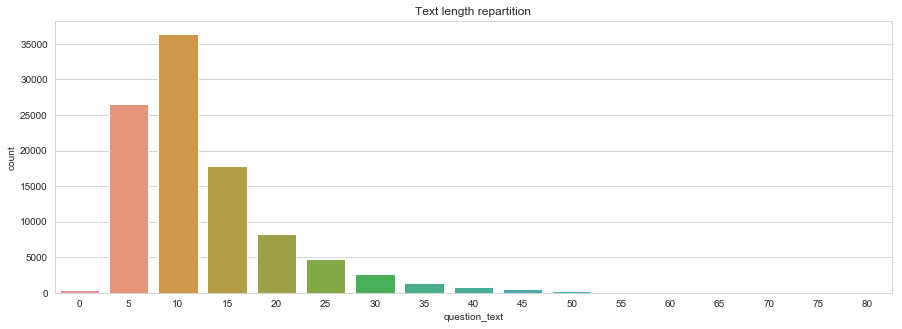

In [35]:
lengths = train_df['question_text'].apply(lambda x: len(x.split(' ')) // 5 * 5)
plt.figure(figsize=(15, 5))
sns.countplot(lengths)
plt.title('Text length repartition')
plt.show()

In [36]:
max_len = 70

print('Maximum sentence length used :', max_len)

Maximum sentence length used : 70


In [37]:
def make_input_data(X_train, X_test):
    t = Tokenizer(num_words=None, filters='', lower=False)
    t.fit_on_texts((np.concatenate((X_train, X_test), axis=0)))
    X_train = t.texts_to_sequences(X_train)
    X_test = t.texts_to_sequences(X_test)
    X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
    X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

    return X_train, X_test, t.word_index

In [38]:
%%time
X_train, X_test, word_index = make_input_data(train_df['question_text'], test_df['question_text'])

Wall time: 11.8 s


In [39]:
len_voc = len(word_index) + 1

print('Number of words in vocabulary : ', len_voc)

Number of words in vocabulary :  134867


## Features

In [40]:
features_train = train_df[features].fillna(0)
features_test = test_df[features].fillna(0)

In [41]:
ss = StandardScaler()
ss.fit(np.vstack((features_train.astype(float), features_test.astype(float))))
features_train = ss.transform(features_train.astype(float))
features_test = ss.transform(features_test.astype(float))

In [42]:
nb_features = len(features)
print(f"Generated {nb_features} features : {', '.join(features)}")

Generated 5 features : length, caps_ratio, unique_words_ratio, toxic_words_ratio, word_freq


## Targets

In [43]:
y_train = train_df['target'].values

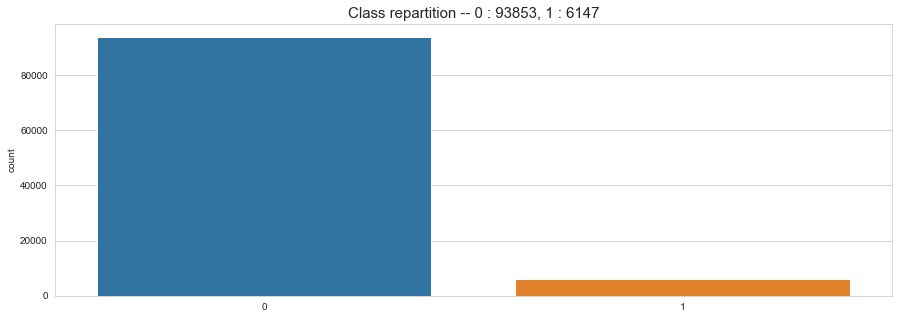

In [44]:
plt.figure(figsize=(15, 5))
sns.countplot(y_train)
plt.title(f'Class repartition -- 0 : {Counter(y_train)[0]}, 1 : {Counter(y_train)[1]}', size=15)
plt.show()

In [45]:
y_test = np.zeros(len(test_df))

# Embedding matrices

## Vocabulary

In [46]:
def build_vocab(texts):
    vocab = {}
    for sentence in texts:
        for word in sentence.split(' '):
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [47]:
vocab = build_vocab(list(train_df["question_text"]) + list(test_df["question_text"]))

## Build Matrices

In [48]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == FASTTEXT:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding="utf8") if len(o)>100 and o.split(" ")[0] in word_index )
    if file == PARAGRAM:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding="utf8", errors='ignore') if len(o)>100 and o.split(" ")[0] in word_index)
    else: #GloVe
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding="utf8") if o.split(" ")[0] in word_index)
        
    return embeddings_index

In [49]:
def make_embed_index(file, word_index, vocab=[], exceptions={}):
    embeddings_index = load_embed(file)
 
    for word in vocab:
        try:
            _ = embeddings_index[word]
        except:
            try:
                embeddings_index[word] = embeddings_index[word.lower()]
            except:
                try:
                    embeddings_index[word] = embeddings_index[word.upper()]
                except:
                    try:
                        embeddings_index[word] = embeddings_index[word[0].upper() + word[1:].lower()]
                    except:
                        pass
            
    return embeddings_index

In [50]:
def make_embed_mat(embeddings_index):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (len(word_index)+1, embed_size))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [51]:
%%time
glove_index = make_embed_index(GLOVE, word_index, vocab)
fasttext_index = make_embed_index(FASTTEXT, word_index, vocab)
para_index = make_embed_index(PARAGRAM, word_index, vocab)

Wall time: 2min 11s


In [52]:
embed_concat = np.concatenate((make_embed_mat(fasttext_index), 
                               make_embed_mat(glove_index), 
                               make_embed_mat(para_index)), axis=1)

## Coverage

In [53]:
def check_coverage(vocab, embeddings_index, word_index=None):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [54]:
print("Glove : ")
oov_glove = check_coverage(vocab, glove_index, word_index)
print("Paragram : ")
oov_paragram = check_coverage(vocab, para_index, word_index)
print("FastText : ")
oov_fasttext = check_coverage(vocab, fasttext_index, word_index)

Glove : 
Found embeddings for 83.63% of vocab
Found embeddings for  99.59% of all text
Paragram : 
Found embeddings for 62.86% of vocab
Found embeddings for  96.92% of all text
FastText : 
Found embeddings for 79.01% of vocab
Found embeddings for  99.47% of all text


In [55]:
for word in np.array(oov_glove)[:100, 0]:
    if word in np.array(oov_paragram)[:, 0] and word in np.array(oov_fasttext)[:, 0]:
        print(word, end='\t')

Quorans	CEo	CoMEDK	ToEFL	BPo	IPo	IoCL	oET	onePlus	Machedo	CoEP	BNBR	UCEED	JSoN	CTo	ICos	LNMIIT	DRDo	ASoIAF	oDI	PCoS	AlShamsi	bhakts	NICMAR	oMR	Vajiram	MooC	RMo	oTG	Awdhesh	Zerodha	GMo	Unacademy	Doklam	Kavalireddi	Bhakts	HBo	eLitmus	MUoET	HackerRank	Binance	Koinex	Alshamsi	unacademy	AIATS	BMSCE	BIPC	LBSNAA	ReactJS	oBoR	MooCs	chapterwise	IISERs	Byju	Skripal	Trumpcare	undergraduation	AKTU	RoTC	SCoTUS	MMMUT	IIITD	

In [56]:
t_init = time.time()
print(f"Initialized in {(t_init - begin) // 60} minutes")

Initialized in 8.0 minutes


# PyTorch Tools

## Dataset

In [57]:
class QuoraDataset(Dataset):
    def __init__(self, texts, features, y):
        self.texts = texts
        self.y = y
        self.features = features
        
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.texts[idx], self.features[idx], self.y[idx]

## To Tensor

In [58]:
def to_tensor(batch):
    texts = [b[0] for b in batch]
    fts = np.array([b[1] for b in batch])
    ys = np.array([b[2] for b in batch])
    
    return torch.tensor(texts, dtype=torch.long), torch.tensor(fts, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

## Sigmoid

In [59]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Noise

In [60]:
class Noise(nn.Module):
    def __init__(self, mean=0.0, stddev=0.1):
        super(Noise, self).__init__()
        self.mean = mean
        self.stddev = stddev

    def forward(self, input):
        noise = input.clone().normal_(self.mean, self.stddev)
        return input + noise

## Attention Layer

In [61]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.supports_masking = True
        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim
        eij = torch.mm(x.contiguous().view(-1, feature_dim), self.weight).view(-1, step_dim)
        if self.bias:
            eij = eij + self.b  
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        if mask is not None: 
            a = a * mask
        a = a / torch.sum(a, 1, keepdim=True) + 1e-10
        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

# Model

- Word-level architecture
- Basically plugging Recurrent Neural Networks onto embeddings
- Pooling & Attention are good ways to handle sequential data
- Add regularization & proper activation functions

In [62]:
class Model(nn.Module):
    def __init__(self, embedding_matrix):
        super(Model, self).__init__()
        
        h1 = 64
        h2 = 32
        hd = 32
        
        voc_size = embedding_matrix.shape[0]
        ft_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(voc_size, ft_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.noise = Noise(stddev=0.05)
        
        self.lstm = nn.LSTM(embedding_matrix.shape[1], 2*h1, batch_first=True)
        self.gru = nn.GRU(2*h1, 2*h2, batch_first=True)
        
        self.lstm_att = Attention(2*h1, max_len)
        self.gru_att = Attention(2*h2, max_len)
        
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(6*(h1+h2) + nb_features, hd)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hd, momentum=0.5)
        self.out = nn.Linear(hd, 1)

In [63]:
    def forward(self, x, ft):
        embed = self.embedding(x)
        
        if self.training: 
            embed = torch.squeeze(self.noise(torch.unsqueeze(embed, 0)))
        
        lstm, _ = self.lstm(embed)
        gru, _ = self.gru(lstm)
        
        att1 = self.lstm_att(lstm)
        att2 = self.gru_att(gru)
        
        avg_pool1 = torch.mean(lstm, 1)
        avg_pool2 = torch.mean(gru, 1)
        max_pool1, _ = torch.max(lstm, 1)
        max_pool2, _ = torch.max(gru, 1)
        
        conc = torch.cat((att1, avg_pool1, max_pool1, att2, avg_pool2, max_pool2, ft), 1)
        conc = self.dropout(conc)
        conc = self.bn(self.relu(self.linear(conc)))
        conc = self.dropout(conc)
        out = self.out(conc)
        
        return out

In [64]:
class Model(nn.Module):
    def __init__(self, embedding_matrix):
        super(Model, self).__init__()
        
        h1 = 64
        h2 = 32
        hd = 32
        
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.noise = Noise(stddev=0.05)
        
        self.lstm = nn.LSTM(embedding_matrix.shape[1], 2*h1, batch_first=True)
        self.gru = nn.GRU(2*h1, 2*h2, batch_first=True)
        
        self.lstm_att = Attention(2*h1, max_len)
        self.gru_att = Attention(2*h2, max_len)
        
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(6*(h1+h2) + nb_features, hd)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hd, momentum=0.5)
        self.out = nn.Linear(hd, 1)
    
    def forward(self, x, ft):
        embed = self.embedding(x)
        
        if self.training: 
            embed = torch.squeeze(self.noise(torch.unsqueeze(embed, 0)))
        
        lstm, _ = self.lstm(embed)
        gru, _ = self.gru(lstm)
        
        att1 = self.lstm_att(lstm)
        att2 = self.gru_att(gru)
        
        avg_pool1 = torch.mean(lstm, 1)
        avg_pool2 = torch.mean(gru, 1)
        max_pool1, _ = torch.max(lstm, 1)
        max_pool2, _ = torch.max(gru, 1)
        
        conc = torch.cat((att1, avg_pool1, max_pool1, att2, avg_pool2, max_pool2, ft), 1)
        conc = self.dropout(conc)
        conc = self.bn(self.relu(self.linear(conc)))
        conc = self.dropout(conc)
        out = self.out(conc)
        
        return out

## Learning rate

In [65]:
def get_lr(epoch):
    if epoch <= 3:
        return 0.001
    else:
        return 0.0005

# Modeling Tools

## Tweak Threshold

In [66]:
def tweak_threshold(train_preds, y_train):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in np.arange(0.1, 0.501, 0.01):
        tmp[1] = f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    return tmp[2], delta

## Fit

In [67]:
def fit(model, train_dataset, val_dataset, epochs=5, batch_size=512, verbose=5):
    best_loss = 1000
    model
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        
 
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=to_tensor, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, collate_fn=to_tensor, shuffle=False)

    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        start_time = time.time()  
            
        try:
            scheduler.batch_step()
        except: 
            lr = get_lr(epoch)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        for x, ft, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x, ft).squeeze()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_dataset)
    
        model.eval()
        
        avg_val_loss = 0.
        
        temp_preds = []
        temp_truths = []
        for x, ft, y_batch in val_loader:
            y_pred = model(x, ft).squeeze().detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(val_dataset)

        elapsed_time = time.time() - start_time    
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            print('Epoch {}/{} \t lr={} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(epoch+1, epochs, lr, avg_loss, avg_val_loss, elapsed_time))

## Predict

In [68]:
def predict(dataset, model, batch_size=2048):
    y = np.array([])
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=to_tensor, shuffle=False)
    for x, ft, target in loader:
        y = np.concatenate((y, sigmoid(model(x, ft).detach().cpu().squeeze().numpy())))
    return y

## $k$-fold

In [69]:
def k_fold(model_class, embed, x, ft, y, x_test, ft_test, y_test, 
           k=5, batch_size=512, epochs=5, seed=2019, verbose=1):
    
    splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=seed).split(x, y))
    
    pred_test = np.zeros(y_test.shape[0])
    pred_oof = np.zeros(y.shape[0])
    
    for i, (train_idx, val_idx) in enumerate(splits):
        print(f"-------------   Fold {i+1}  ------------- \n")
        seed_everything(seed + i)
        start_time = time.time()
        
        model = model_class(embed)
        
        train_dataset = QuoraDataset(x[train_idx], ft[train_idx], y[train_idx])
        val_dataset = QuoraDataset(x[val_idx], ft[val_idx], y[val_idx])
        test_dataset = QuoraDataset(x_test, ft_test, y_test)
        
        fit(model, train_dataset, val_dataset, epochs=epochs, batch_size=batch_size, verbose=verbose)
        pred_val = predict(val_dataset, model)
        pred_oof[val_idx] = pred_val
        pred_test += predict(test_dataset, model) / k
        
        score, threshold = tweak_threshold(pred_val, y[val_idx])
        
        print(f"\n Scored {score :.4f} for threshold {threshold :.3f} on validation data")
        
        print(f"\n    Done in {(time.time() - start_time) / 60 :.1f} minutes \n")
        
    return pred_test, pred_oof

# Training

- Folds : 5
- Epochs : 4
- Learning rates : 0.001 for the first 3 epochs, 0.0005 for the last one
- Batch size : 512
- Loss : Binary Crossentropy
- Optimizer : Adam

In [70]:
pred_test, pred_oof= k_fold(Model, embed_concat, X_train, features_train, y_train, X_test, features_test, y_test, 
                            k=5, batch_size=512, epochs=4)

-------------   Fold 1  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.4790 	 val_loss=0.2591 	 time=392.46s
Epoch 2/4 	 lr=0.001 	 loss=0.1706 	 val_loss=0.1333 	 time=406.56s
Epoch 3/4 	 lr=0.001 	 loss=0.1150 	 val_loss=0.1193 	 time=386.50s
Epoch 4/4 	 lr=0.001 	 loss=0.0985 	 val_loss=0.1160 	 time=393.41s

 Scored 0.6223 for threshold 0.280 on validation data

    Done in 37.5 minutes 

-------------   Fold 2  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.5058 	 val_loss=0.3322 	 time=366.37s
Epoch 2/4 	 lr=0.001 	 loss=0.1766 	 val_loss=0.1329 	 time=3239.23s
Epoch 3/4 	 lr=0.001 	 loss=0.1176 	 val_loss=0.1144 	 time=1429.78s
Epoch 4/4 	 lr=0.001 	 loss=0.0989 	 val_loss=0.1125 	 time=331.89s

 Scored 0.6421 for threshold 0.220 on validation data

    Done in 98.9 minutes 

-------------   Fold 3  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.4101 	 val_loss=0.2657 	 time=336.24s
Epoch 2/4 	 lr=0.001 	 loss=0.1584 	 val_loss=0.1285 	 time=363.78s
Epoch 3/4 	 lr=0.001 	 loss=0.11

## Cross Validation Score

In [71]:
score, threshold = tweak_threshold(pred_oof, y_train)

print(f'Local CV is {score:.4f} for threshold {threshold:.3f}')

Local CV is 0.6341 for threshold 0.280


## Test prediction

In [72]:
label_test = (pred_test > threshold).astype(int)

In [73]:
for l, q in zip(test_df["question_text"][:5], label_test[:5]):
    print(l)
    print(f'Labelled {q}')
    print('')

Why do so many women become so rude and arrogant when they get just a little bit of wealth and power ?
Labelled 1

When should I apply for RV college of engineering and BMS college of engineering ? Should I wait for the CoMEDK result or am I supposed to apply before the result ?
Labelled 0

What is it really like to be a nurse practitioner ?
Labelled 0

Who are entrepreneurs ?
Labelled 0

Is education really making good people nowadays ?
Labelled 0



In [74]:
output = pd.DataFrame({"qid": test_df["qid"].values})
output['prediction'] = label_test
output.to_csv("submission.csv", index=False)

In [75]:
output.head()

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


In [76]:
print(f"Ended in {(time.time() - begin) / 60 :.1f} minutes")

Ended in 258.3 minutes


https://www.kaggle.com/theoviel/fork-of-quora-cv-framework-2dba88?scriptVersionId=10265482

<img src="../img/score.png">

**The end.**

https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification